In [1]:
import torch
import time
import gc
import math
from scipy import ndimage
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import pickle
import random
from torchvision import transforms

from skimage import data, img_as_float
from skimage.measure import compare_ssim as ssim

import sys
sys.path.append('../code')
from python.commons import full_inference_e2e, inc_inference_e2e, generate_heatmap, load_dict_from_hdf5
from python.imagenet_classes import class_names
from python.vgg16 import VGG16
from python.resnet18 import ResNet18
from python.inception3 import Inception3

random.seed(45)
np.random.seed(45)

torch.set_num_threads(8)

image_file_path = "../data/oct/test/DME/DME-119840-17.jpeg"
# image_file_path = "../data/oct/validation/DRUSEN/DRUSEN-5333808-1.jpeg"
# image_file_path = "../code/python/dog_resized.jpg"

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
model = ResNet18
patch_size = 16
stride = 1
c = 0.0
image_size = 224
gpu = True

In [3]:
weight_files = {
    VGG16 : '../code/python/vgg16_weights_ptch.h5',
    ResNet18 : '../code/python/resnet18_weights_ptch.h5',
    Inception3 : '../code/python/inception3_weights_ptch.h5'
}

fine_tuned_weight_files = {
    VGG16 : './oct_vgg16_ptch.h5',
    ResNet18 : './oct_resnet18_ptch.h5',
    Inception3 : './oct_inception3_ptch.h5'
}

weights_data = load_dict_from_hdf5(weight_files[model], gpu=gpu)
file_tuned_weight_data = load_dict_from_hdf5(fine_tuned_weight_files[model], gpu=gpu)
    
if model == VGG16:
    weights_data['fc8_W:0'] = file_tuned_weight_data['fc8_W:0']
    weights_data['fc8_b:0'] = file_tuned_weight_data['fc8_b:0']
elif model == ResNet18:
    weights_data['fc:w'] = file_tuned_weight_data['fc:w']
    weights_data['fc:b'] = file_tuned_weight_data['fc:b']
elif model == Inception3:
    weights_data['482.fc.weight'] = file_tuned_weight_data['482.fc.weight']
    weights_data['483.fc.bias'] = file_tuned_weight_data['483.fc.bias']

In [4]:
if gpu:
    torch.cuda.synchronize()

prev_time = time.time()
with torch.no_grad():
    x, prob = full_inference_e2e(model, image_file_path, patch_size, stride,
                           batch_size=128, gpu=gpu, image_size=image_size, x_size=image_size,
                           y_size=image_size, weights_data=weights_data, c=c)

if gpu:
    torch.cuda.synchronize()

full_inference_time = time.time() - prev_time
print("Full Inference Time: " + str(full_inference_time))

Full Inference Time: 21.3636519909


/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


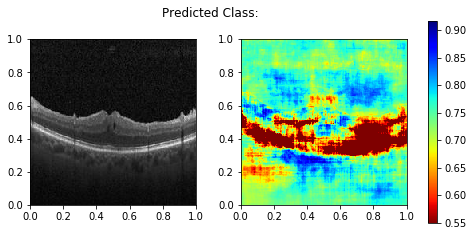

In [5]:
orig_hm  =  generate_heatmap(image_file_path, x, show=True, width=image_size, alpha=1.0, prob=prob)

output = open('temp', 'w')
pickle.dump(orig_hm, output)
output.close()

In [6]:
def inc_inference_selected(model, file_path, patch_size, stride, patch_positions, batch_size=64, beta=1.0,
                           x0=0, y0=0, image_size=224, x_size=224, y_size=224, gpu=True, version='v1',
                           n_labels=1000, weights_data=None, loader=None, c=0.0):

    if loader == None:
        loader = transforms.Compose([transforms.Resize([image_size, image_size]), transforms.ToTensor()])
    orig_image = Image.open(file_path).convert('RGB')
    orig_image = loader(orig_image).unsqueeze(0)

    if gpu:
        orig_image = orig_image.cuda()

    image_patches = torch.FloatTensor(3, patch_size, patch_size).fill_(c).repeat(batch_size, 1, 1, 1)
        
    x_output_width = int(math.ceil((x_size*1.0 - patch_size) / stride))
    y_output_width = int(math.ceil((y_size*1.0 - patch_size) / stride))

    total_number = x_output_width * y_output_width
    logit_values = np.zeros((x_output_width, y_output_width), dtype=np.float32)
    
    num_batches = int(math.ceil(len(patch_positions) * 1.0 / batch_size))
    inc_model = model(beta=beta, gpu=gpu, n_labels=n_labels, weights_data=weights_data).eval()
    
    if gpu:
        inc_model = inc_model.cuda()
        
    temp = inc_model.forward_materialized(orig_image).cpu().data.numpy()
    logit_index = np.argmax(temp)
    prob = np.max(temp)
 
    locations = torch.zeros([batch_size, 2], dtype=torch.int32)
    
    for i in range(num_batches):
        for j in range(batch_size):
            index = j * num_batches + i
            if index >= len(patch_positions):
                break

            x, y = patch_positions[index]
            x = x*stride + x0
            y = y*stride + y0
            x,y = int(x), int(y)
            
            locations[j, 0] = x
            locations[j, 1] = y

        if version == 'v1':
            logits = inc_model.forward_gpu(image_patches, locations, p_height=patch_size, p_width=patch_size)
        else:
            logits = inc_model.forward_pytorch(image_patches, locations, p_height=patch_size, p_width=patch_size)
            
        logits = logits.cpu().data.numpy()[:, logit_index].flatten().tolist()

        for logit, j in zip(logits, range(batch_size)):
            index = j * num_batches + i
            if index >= len(patch_positions):
                break
            x, y = patch_positions[index]
            logit_values[x, y] = logit

    del inc_model
    gc.collect()

    return logit_values, prob



def adaptive_drilldown(model, file_path, patch_size, stride, batch_size=128, image_size=224,
                       x_size=224, y_size=224, beta=1.0, percentile=25, gpu=True, version='v1',
                       n_labels=1000, weights_data=None, loader=None, c=0.0):
    final_out_width = int(math.ceil((image_size*1.0-patch_size)/stride))

    #checking for interested regions
    temp1, prob = inc_inference_e2e(model, file_path, 16, 16,
                                    batch_size=batch_size, beta=beta, image_size=image_size, x_size=x_size,
                              y_size=y_size, gpu=gpu, version=version, weights_data=weights_data, loader=loader, c=c)

    temp1 = cv2.resize(temp1, (final_out_width, final_out_width), interpolation=cv2.INTER_LINEAR)
    threshold = np.percentile(temp1, percentile)
    temp1 = np.where(temp1 <= threshold, 0, temp1)
    idx = np.argwhere(temp1 <= threshold)
    
    #drilldown into interested regions
    temp2, prob = inc_inference_selected(model, file_path, patch_size, stride, idx.tolist(),
                                    batch_size=batch_size, beta=beta, image_size=image_size,
                              x_size=image_size, y_size=image_size, gpu=gpu, version=version,
                            weights_data=weights_data, loader=loader, c=c)

    
    
    return np.add(temp1, temp2), prob


def inc_inference(beta, patch_size=4, stride=1, adaptive=False, weights_data=None):
    if gpu:
        torch.cuda.synchronize()
    
    if not adaptive:
        with torch.no_grad():
            x, prob = inc_inference_e2e(model, image_file_path, patch_size, stride,
                                  batch_size=256, beta=beta, gpu=gpu, version='v1',
                                 image_size=image_size, x_size=image_size, y_size=image_size,
                                 weights_data=weights_data)
    else:
        with torch.no_grad():
            x, prob = adaptive_drilldown(model, image_file_path, patch_size, stride,
                                    batch_size=256, beta=beta, gpu=gpu, version='v1', percentile=20,
                                  image_size=image_size, x_size=image_size, y_size=image_size,
                                  weights_data=weights_data)
    if gpu:
        torch.cuda.synchronize()

    return x, prob

BETA: 1.0 Inference Time: 3.26563191414


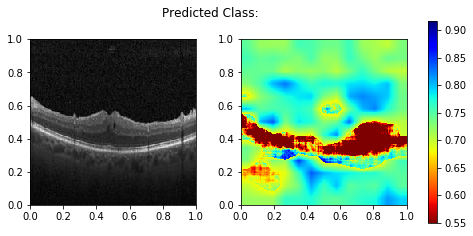

BETA: 0.9 Inference Time: 2.91253089905


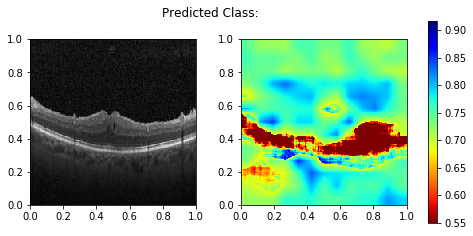

BETA: 0.8 Inference Time: 2.78384208679


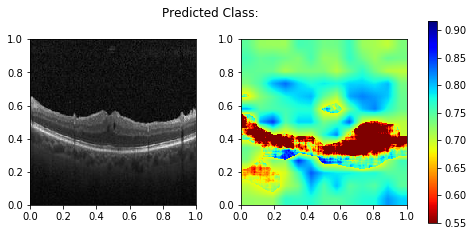

BETA: 0.7 Inference Time: 2.34246397018


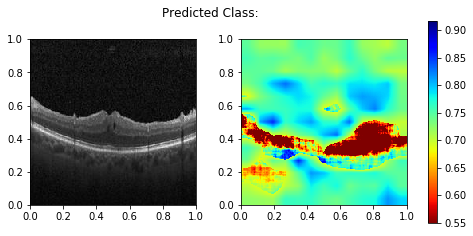

BETA: 0.6 Inference Time: 2.07900190353


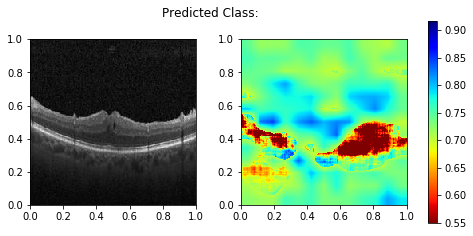

BETA: 0.5 Inference Time: 1.94824910164


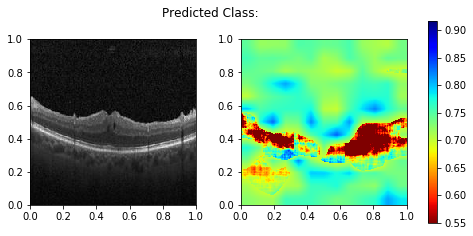

BETA: 0.4 Inference Time: 1.66903305054


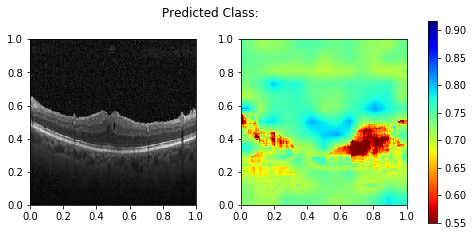

In [10]:
orig_hm = pickle.load(open('temp', 'r'))

times = []
score = []

taus = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4]

for beta in taus:
    prev_time = time.time()
    x, prob = inc_inference(beta, patch_size=patch_size, stride=stride, adaptive=True, weights_data=weights_data)
    inc_inference_time = time.time()-prev_time
    times.append(inc_inference_time)
    
    label = "BETA: " + str(beta) +" Inference Time: " + str(inc_inference_time)
    print(label)
    hm = generate_heatmap(image_file_path, x, show=True, width=224, alpha=1.0, prob=prob)
    
    if hm.shape[0] < 7:
        win_size=3
    else:
        win_size=None
    
    score.append(ssim(orig_hm, hm, data_range=255, multichannel=True, win_size=win_size))

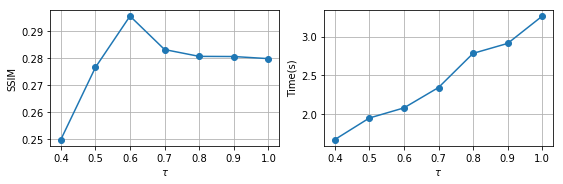

In [11]:
plt.figure(figsize=(9,2.5))

plt.subplot(1,2,1)
plt.plot(taus, score, marker='o')
plt.ylabel('SSIM')
plt.xlabel(r'$\tau$')
plt.grid()

plt.subplot(1,2,2)
plt.plot(taus, times, marker='o')
plt.ylabel('Time(s)')
plt.xlabel(r'$\tau$')
plt.grid()

plt.show()